In [1]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np 
import glob, os, subprocess
from dateutil import parser

import matplotlib.pyplot as plt
import matplotlib
import datacube
import sys, shutil
sys.path.append("..")

from SRC import *

%matplotlib notebook
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams['savefig.dpi'] = 300


indir = '/g/data/u46/users/aw3463/GuyByrne/calval/FLAME/MULLION/04MAY20/flame_data/10m_lines/'
outdir = '/g/data1a/u46/users/aw3463/GuyByrne/calval/FLAME/PNGS/MULLION/04MAY20/'
calfile = '/g/data/u46/users/aw3463/GuyByrne/calval/FLAME/CALIBRATION/RadCalCoeff_GT08_.csv'
TelemetryFile = '/g/data/u46/users/aw3463/GuyByrne/calval/FLAME/MULLION/04MAY20/log_files/May-4th-2020-10-06AM-Flight-Airdata.csv'


field_data = ['MUL', '04MAY20', '', 'Sentinel2b', 'GA_Panel', 'Radiance', '', '']

fignum=1


#
# Define the first line and spectrum number for all/good panels and grounds
#
firstGoodLine = 1
firstGoodPanelSpec = 0
firstGoodGroundSpec = 1724

brdf_data = np.array([['', 'brdf0', 'brdf1', 'brdf2'],
                          ['band1', 0.06538, 0.01958666666666667, 0.009953333333333333],
                          ['band11', 0.39993333333333336, 0.11646333333333335, 0.05016],
                          ['band12', 0.2479, 0.061623333333333336, 0.03579333333333334],
                          ['band2', 0.06538, 0.01958666666666667, 0.009953333333333333],
                          ['band3', 0.11231, 0.04193666666666667, 0.01812666666666667],
                          ['band4', 0.12977000000000002, 0.04653666666666667, 0.02082666666666667],
                          ['band5', 0.12977000000000002, 0.04653666666666667, 0.02082666666666667],
                          ['band6', 0.12977000000000002, 0.04653666666666667, 0.02082666666666667],
                          ['band7', 0.32748000000000005, 0.16837333333333335, 0.03345],
                          ['band8', 0.32748000000000005, 0.16837333333333335, 0.03345],
                          ['band8a', 0.32748000000000005, 0.16837333333333335, 0.03345],
                         ])

plot_scale = [0.0, 1.0, 0.0, 1.0]
Corners = [0, 0, 0, 0, 0, 0, 0, 0]
RockWalk = True
StartCorner = 'SE'
panel_dir =  '/g/data1a/u46/users/aw3463/GuyByrne/30APR18/Panels/'
in_panel = 'ga_panel1_jan_2018.txt'

sat_resp = dict({'Landsat5': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/landsat5_vsir.flt', 
            'Landsat7': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/landsat7_vsir.flt', 
            'Landsat8': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/landsat8_vsir.flt',
            'Sentinel2a': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/Sent2a.flt',
            'Sentinel2b': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/Sent2b.flt'})

f_name = sat_resp[field_data[3]]

#
# Colours used for plotting multi-coloured Lines
#
colpac=['#770000', '#FF0000', '#FF7700', '#FFFF00', '#77FF00', '#00FF00', 
        '#00FF77', '#00FFFF', '#0077FF', '#0000FF', '#000077', '#FF00FF', '#777777', '#770077', '#777700']



In [2]:
TeleDat = pd.read_csv(TelemetryFile)
#TeleDat1 = pd.read_csv(TelemetryFile1)
#TeleDat2 = pd.read_csv(TelemetryFile2)
#TeleDat = pd.concat([TeleDat1, TeleDat2])

In [3]:
TeleDat.drop(['height_above_ground_at_drone_location(meters)', 
              'ground_elevation_at_drone_location(meters)',
              'satellites',
              'gpslevel',
              'voltage(v)',
              'max_altitude(meters)',
              'max_ascent(meters)',
              'max_speed(m/s)',
              'max_distance(meters)',
              ' xSpeed(m/s)',
              ' ySpeed(m/s)',
              ' zSpeed(m/s)',
              'isPhoto',
              'isVideo',
              'rc_elevator',
              'rc_aileron',
              'rc_throttle',
              'rc_rudder',
              'battery_percent',
              'voltageCell1',
              'voltageCell2',
              'voltageCell3',
              'voltageCell4',
              'voltageCell5',
              'voltageCell6',
              'current(A)',
              'battery_temperature(c)',
              'altitude(meters)',
              'ascent(meters)',
              'flycStateRaw',
              'flycState'], axis=1, inplace=True)

In [4]:
TeleDat.rename(columns={'time(millisecond)': 'time_ms',
                        'datetime(utc)': 'datetime',
                        'latitude': 'Latitude',
                        'longitude': 'Longitude',
                        'height_above_takeoff(meters)': 'height_local',
                        'altitude_above_seaLevel(meters)': 'height_sea',
                        'distance(meters)': 'distance(m)',
                        ' compass_heading(degrees)': 'compass_heading',
                        ' pitch(degrees)': 'pitch',
                        ' roll(degrees)': 'roll',
                        'gimbal_heading(degrees)': 'gimbal_heading',
                        'gimbal_pitch(degrees)': 'gimbal_pitch',
                        'message': 'comment'
                       }, inplace=True
              )

In [5]:
TeleDat['datetime'] = [parser.parse(TeleDat.datetime[i]) for i in range(len(TeleDat.datetime))]

In [6]:
TeleDat = TeleDat[TeleDat['datetime'] > datetime(2020,4,14,1,53,0)]

In [7]:
TeleDat['date_saved'] = [TeleDat.datetime.iloc[0] + timedelta(milliseconds=int(TeleDat.time_ms.iloc[i])) + timedelta(milliseconds=900) for i in range(len(TeleDat.datetime))]

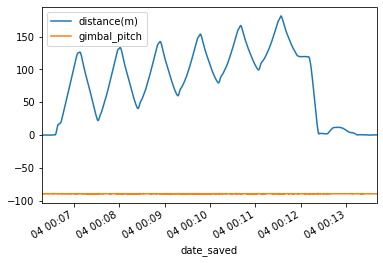

In [8]:
TeleDat.plot('date_saved', ['distance(m)', 'gimbal_pitch'])

In [9]:
TeleDat

,time_ms,datetime,Latitude,Longitude,height_local,height_sea,speed(m/s),distance(m),compass_heading,pitch,roll,gimbal_heading,gimbal_pitch,comment,date_saved
0,0,2020-05-04 00:06:17,-35.123510,148.862611,0.0,578.747925,0.0,0.000000,90.5,1.3,-1.7,180.3,-89.0,NaN,2020-05-04 00:06:17.900
1,100,2020-05-04 00:06:18,-35.123510,148.862611,0.0,578.747925,0.0,0.003218,90.6,1.3,-1.7,179.8,-89.0,NaN,2020-05-04 00:06:18.000
2,200,2020-05-04 00:06:18,-35.123510,148.862611,0.0,578.747925,0.0,0.005704,90.7,1.3,-1.7,179.7,-89.0,NaN,2020-05-04 00:06:18.100
3,300,2020-05-04 00:06:18,-35.123510,148.862611,0.0,578.747925,0.0,0.009292,90.9,1.3,-1.7,179.9,-89.0,NaN,2020-05-04 00:06:18.200
4,400,2020-05-04 00:06:18,-35.123510,148.862611,0.0,578.747925,0.0,0.012701,90.9,1.3,-1.7,180.8,-89.0,NaN,2020-05-04 00:06:18.300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4208,441400,2020-05-04 00:13:39,-35.123506,148.862607,-0.4,578.347925,0.0,0.531200,72.7,1.2,-1.3,182.4,-89.0,NaN,2020-05-04 00:13:39.300
4209,441500,2020-05-04 00:13:39,-35.123506,148.862607,-0.4,578.347925,0.0,0.529857,72.8,1.3,-1.3,179.2,-88.9,NaN,2020-05-04 00:13:39.400
4210,441600,2020-05-04 00:13:39,-35.123506,148.862607,-0.4,578.347925,0.0,0.526105,72.8,1.2,-1.3,180.6,-88.9,NaN,2020-05-04 00:13:39.500
4211,441700,2020-05-04 00:13:39,-35.123506,148.862607,-0.4,578.347925,0.0,0.525896,72.7,1.2,-1.2,180.5,-89.0,NaN,2020-05-04 00:13:39.600


In [10]:
alldata = LoadData.load_from_dir(indir, calfile)

In [11]:
alldata['radiance'] = alldata.DN*alldata.CalData/alldata.IntTime
#alldata['radiance'] = alldata['radiance']/10000
alldata['Line']=1
#alldata['Latitude'] = -35.123277
#alldata['Longitude'] = 148.862692

In [12]:
#
# Bin spectra into integer wavelength bins, assuming that the input data
# has 0.3nm channels.
#
def wavelength_bin(alldata):
    # Create avgdata DataFrame, based on alldata input DataFrame
    # Reset index so that Wavelength is not the index.
    avgdata = alldata.copy()
    avgdata.reset_index(inplace=True)
    
    ### Make a mean of three rows for each of DN, Calibration, Radiance
    ###avgdata['DNmean'] = avgdata.DN.rolling(3, center=True).mean()
    ###avgdata['Calmean'] = avgdata.CalData.rolling(3, center=True).mean()
    ###avgdata['Radmean'] = avgdata.radiance.rolling(3, center=True).mean()
    
    # Remove first and last wavelengths which have NaNs in them.
    avgdata = avgdata[avgdata.Wavelength != 349.176]
    avgdata = avgdata[avgdata.Wavelength != 910.925]
    
    # Create empty output DataFrame
    outputDF = pd.DataFrame()
    ttmm = pd.DataFrame()
    
    # Loop through each spectrum in the dataframe
    for j in avgdata.SpecNum.unique():
        tempdata = avgdata[avgdata.SpecNum==j].groupby(pd.cut(avgdata[avgdata.SpecNum==j]['Wavelength'], np.arange(349.5,910.5,1.0))).mean()
        tempdata['date_saved'] = avgdata[avgdata.SpecNum==j].date_saved.values[0]
        tempdata['filename'] = avgdata[avgdata.SpecNum==j].filename.values[0]
        
        tempdata.index.rename('plop', inplace=True)
        tempdata.reset_index(inplace=True)
        tempdata.drop(columns='plop', inplace=True)
        tempdata.Wavelength = tempdata.Wavelength.round(0).astype(int)        
        
        # When finished making an entire spectrum, add it to the output DataFrame
        # and print how many have been done.
        if outputDF.empty:
            outputDF = tempdata.copy()
        
        else:
            if j % 100 == 0:
                ttmm = pd.concat([ttmm, tempdata])
                outputDF = pd.concat([outputDF, ttmm])
                ttmm = pd.DataFrame()
            
            elif j == len(avgdata.SpecNum.unique())-1:
                ttmm = pd.concat([ttmm, tempdata])
                outputDF = pd.concat([outputDF, ttmm])
            
            elif ttmm.empty:
                ttmm = tempdata.copy()
            
            else:
                ttmm = pd.concat([ttmm, tempdata])
                
            
        print('Completed ', j+1, '/', len(avgdata.SpecNum.unique()), ' spectra', end='\r', flush=True)

    # output final DataFrame
    return outputDF

avgdata = wavelength_bin(alldata)

In [13]:
alldat = avgdata.reset_index()

In [14]:
merge_data = pd.merge_asof(avgdata, TeleDat, on='date_saved')

In [15]:
#plop = plop.set_index('Wavelength')

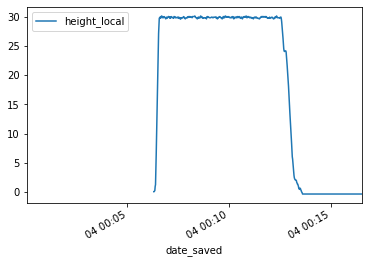

In [16]:
merge_data.plot('date_saved', 'height_local')

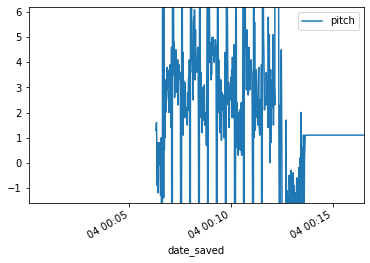

In [17]:
merge_data.plot('date_saved', 'pitch', ylim=(-1.6, 6.2))

In [18]:
def scatter_plot(xdata, ydata):
    plt.scatter(xdata, ydata, s=3)
    plt.xlim(xdata.min(), xdata.max())
    plt.ylim(ydata.min(), ydata.max())

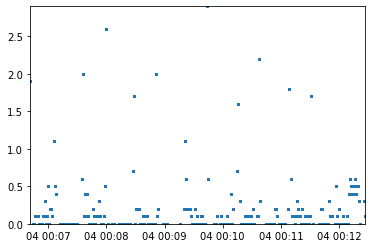

In [19]:
scatter_plot(merge_data[merge_data.compass_heading <10]['date_saved'], merge_data[merge_data.compass_heading <10]['compass_heading'])

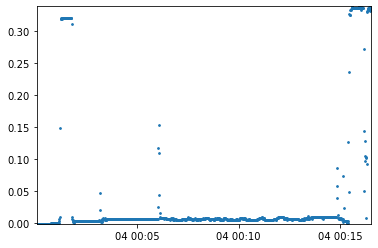

In [20]:
scatter_plot(merge_data[merge_data.Wavelength==450]['date_saved'], merge_data[merge_data.Wavelength==450]['radiance'])
#scatter_plot(merge_data[merge_data.Wavelength==450]['date_saved'], merge_data[merge_data.Wavelength==450]['height_local'])
plt.savefig('moo.png')

In [21]:
tmp_panels = merge_data[np.logical_and(merge_data.Wavelength==450, merge_data.radiance > 50)]

In [22]:
bad_times = [datetime(2020,5,4,0,15,54,469000), 
             datetime(2020,5,4,0,16,1,547000)]

for i in bad_times:
    tmp_panels = tmp_panels[tmp_panels.date_saved != i]
    
tmp_panels = tmp_panels[tmp_panels.date_saved < datetime(2020,5,4,0,16,10)]
#tmp_panels = tmp_panels[tmp_panels.date_saved < datetime(2020,5,4,0,16,10)]


#datetime(2020,5,4,0,15,35)
#all_panels = all_panels[all_panels.date_saved != (datetime(2020,4,24,0,28,24,515000))]


In [23]:
all_panels = merge_data.loc[merge_data['date_saved'].isin(tmp_panels.date_saved)]

In [24]:
all_panel_spec = MakeSpecDF.make_spec_df(all_panels)

TypeError: no numeric data to plot

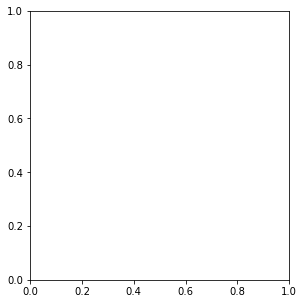

In [25]:
FIG_PanelRadiances.FIG_panel_radiances(all_panel_spec, outdir, field_data, fignum)

fignum += 1

In [ ]:
merge_data = merge_data[merge_data.Latitude < 0]
merge_data = merge_data[merge_data.height_local > 29.5]
merge_data = merge_data[merge_data.pitch > -1.6]
merge_data = merge_data[merge_data.pitch < 6.2]
merge_data = merge_data[np.logical_or(merge_data.compass_heading > 358, merge_data.compass_heading < 1)]

In [ ]:
merge_data[merge_data.Wavelength==350].date_saved

In [ ]:
all_grounds = merge_data[merge_data.date_saved < datetime(2020,5,4,0,12,20)]

In [ ]:
merge_data[merge_data.Wavelength==450].plot('date_saved', 'radiance')

In [ ]:
all_grounds_spec = MakeSpecDF.make_spec_df(all_grounds)

In [ ]:
FIG_GroundSpectra.FIG_ground_spectra(all_grounds_spec, outdir, field_data, fignum)
fignum +=1

In [ ]:
scatter_plot(merge_data[merge_data.Wavelength==350]['Longitude'], merge_data[merge_data.Wavelength==350]['Latitude'])

In [ ]:
all_panels.Longitude = all_panels.Longitude.fillna(all_panels.Longitude.min())
all_panels.Latitude = all_panels.Latitude.fillna(all_panels.Latitude.min())

all_grounds.Longitude = all_grounds.Longitude.fillna(all_grounds.Longitude.min())
all_grounds.Latitude = all_grounds.Latitude.fillna(all_grounds.Latitude.min())

In [ ]:
all_panels, all_grounds = SolarAngle.solar_angle(all_panels, all_grounds, field_data)

In [ ]:
good_panels = all_panels.copy()
good_grounds = all_grounds.copy()

In [ ]:
all_panels = PanelBRF.Panel_BRF(all_panels, field_data)

In [ ]:
gpta, adta = CreateTimeRelativeDF.create_time_relative_dfs(all_panels, all_grounds)

In [ ]:
FIG_AllTimelines.FIG_all_timelines(gpta, adta, outdir, field_data, fignum)
fignum += 1

In [ ]:
all_panel_mean = all_panel_spec.mean(axis=1)

gpta = FIG_NormalisedPanelsTimeline.normalise_spectra(all_panel_mean, all_panel_spec, gpta, field_data)

FIG_NormalisedPanelsTimeline.FIG_normalised_panels_timeline(gpta, outdir, field_data, fignum)

fignum += 1

In [ ]:
gpta['Latitude'] = -35.123277
gpta['Longitude'] = 148.862692
adta['Latitude'] = -35.123277
adta['Longitude'] = 148.862692

In [ ]:
slope, intercept, coszenith = FIG_InsolationFit.FIG_insolation_fit(gpta, outdir, field_data, fignum)
fignum += 1

### Scale good panels to insolation curve

Use the fitted insolation curve to determine individual offsets for each panel measurement and then divide<BR>
off the differences. This effectively removes any individual variations in the absolute scaling of panel<BR>
measurements.

In [ ]:
good_panels = ScalePanels.scale_panels(slope, intercept, coszenith, gpta, good_panels, field_data)

### Scale ground spectra to insolation curve

For each line, calculate the mean panel spectrum and determine the fit at the according mean Solar zenith angle.<BR>
Then determine individual fits for all ground data within the line and apply the ratio of the panel mean fit to<BR>
ground fit to the good_grounds dataframe.

In [ ]:
good_grounds = ScaleGrounds.scale_grounds(good_panels, good_grounds, slope, intercept, field_data)

### Define the K-factor

This reads a standard file with a response curve for the detector, given an ideally white surface.<BR>
Then "k_f" is defined for the K-factor.

In [ ]:
k_f = KFactor.k_factor(panel_dir, in_panel)

In [ ]:
k_f = k_f[k_f.index <910]

### Re-Make Spectral Dataframes

After re-scaling of both good_panels and good_grounds, recreate the good_panel_spec and<BR>
good_grounds_spec dataframes

In [ ]:
good_panel_spec = MakeSpecDF.make_spec_df(good_panels)
good_grounds_spec = MakeSpecDF.make_spec_df(good_grounds)

### Rename the first spectrum in ALL/GOOD panels to the correct name

Rather than just "radiance", it will be named something like radiance1-0<BR>
for the zeroth spectrum in the first line, for example.    

In [ ]:
SpecRename.spec_rename(good_panel_spec, good_grounds_spec, firstGoodLine, firstGoodPanelSpec, firstGoodGroundSpec, field_data)

In [ ]:
good_panel_spec = good_panel_spec.rename(columns={x:y for x,y in zip(good_panel_spec.columns,range(len(good_panel_spec.columns)))}).add_prefix('radiance1-')
good_grounds_spec = good_grounds_spec.rename(columns={x:y for x,y in zip(good_grounds_spec.columns,range(len(good_grounds_spec.columns)))}).add_prefix('radiance1-')


### Create dataframe with Reflectances

In [ ]:
all_refls = CreateReflectances.create_reflectances(good_panels, good_panel_spec, good_grounds_spec, k_f, field_data)

In [ ]:
all_refls

In [ ]:
FIG_Reflectances.FIG_reflectances(good_panels, all_refls, colpac, outdir, field_data, fignum)
fignum += 1

In [ ]:
flameavg = all_refls.mean(axis=1)

In [ ]:
asdavg = pd.read_pickle('04MAY20.pick')

In [ ]:
plt.plot(flameavg)
plt.plot(asdavg)
plt.ylim(0,0.6)
plt.xlim(340,915)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.legend(['Drone average spectrum', 'ASD average spectrum'])
plt.savefig('comp.png')

In [ ]:
(flameavg/asdavg).plot(xlim=(350,910), ylim=(0.5,1))

In [ ]:
plt.scatter(all_panels[all_panels.Wavelength==450].date_saved, all_panels[all_panels.Wavelength==450].radiance)
plt.xlim(datetime(2020,5,4,0,15,35), datetime(2020,5,4,0,16,10))
plt.ylim(57,58.5)

In [ ]:
all_panels[np.logical_and(all_panels.Wavelength==450, all_panels.date_saved > datetime(2020,5,4,0,15,35))].radiance

In [ ]:

all_panels.loc[531540]

### Apply weighted band responses to all reflectances

In [ ]:
ls_result_df, s2_result_df, ls_band, s2_band = ApplyWeights.apply_weights(f_name, all_refls, sat_resp, field_data)

### Reformat band reflectances and apply to dataframe "ground_bands"

In [ ]:
ls_ground_bands = ReformatDF.reformat_df(good_grounds, ls_result_df)
s2_ground_bands = ReformatDF.reformat_df(good_grounds, s2_result_df)

# Figure 

### Plot band reflectances

In [ ]:
FIG_BandReflectances.FIG_band_reflectances(ls_ground_bands, ls_result_df, ls_band, s2_ground_bands, s2_result_df, s2_band, colpac, output, field_data, fignum)

fignum += 1

In [ ]:
FIG_ReflectancesBand.FIG_reflectances_band(ls_ground_bands, ls_result_df, ls_band, s2_ground_bands, s2_result_df, s2_band, good_panels, all_refls, colpac, output, field_data, fignum)

fignum += 1

# Figure

### Histogram of all good spectra, plotted band-by-band

This can be used to identify outlying ground spectra that can be added to bad_grounds in the second cell.

In [ ]:
FIG_SpecHistogram.FIG_spec_histogram(ls_ground_bands, s2_ground_bands, output, field_data, fignum)
fignum += 1

### Outlying ground spectra

Display the spectra with maximum and minimum values. These can be compared to the histograms above<BR>
    to identify any outlying spectra that need to be identified as bad ground spectra.

In [ ]:
OutlyingSpec.outlying_spec(ls_ground_bands, s2_ground_bands, field_data)

### Determine Solar angle

Based on the spectrum Latitude, Longitude and time stamp, calculate the angle of<BR>
the Sun, with respect to the zenith. Append this number to the "ground_bands" dataframe.

In [ ]:
from SRC.SolarAngle import solang
ls_ground_bands['Solar_angle'] = ls_ground_bands.apply(solang, axis=1)
s2_ground_bands['Solar_angle'] = s2_ground_bands.apply(solang, axis=1)

### BRDF Calculation

The following script is adapted from FORTRAN code that will calculate the adjusted ASD measurement to 45$^\circ$. This is derived from "MODIS BRDF / Albedo Product: Algorithm Theoretical basis Docuement Version 5.0" by Strahler et al. (1999).

What follows is a key to the variables used in this code, compared to the variables and equations in the document:

hb and br = h/b and b/r . . . . . . . . . . . . . . . crown shape parameters, respectively.<BR>
RL_brdf = R($\theta, \vartheta, \phi, \Lambda$). . . . . . . . . . . . . . (37)<BR>
solar = $\theta$ . . . . . . . . . . . . . . . . . . . . . . . . . . solar zenith angle<BR>
view = $\xi$ . . . . . . . . . . . . . . . . . . . . . . . . . . .view zenith angle<BR>
ra = $\phi$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . view-sun relative azimuth angle<BR>
cosxi = cos $\xi^\prime$ . . . . . . . . . . . . . . . . . . . . . . (43)<BR>
rs_thick = K$_{vol}$ = RossThick kernel . . . . . . (38)<BR>
d_li2 = D$^2$ . . . . . . . . . . . . . . . . . . . . . . . . . (42)<BR>
x_li = tan$\theta^\prime$ tan$\vartheta^\prime$ sin$\phi$ . . . . . . . . . . . . . . .(41) (part of)<BR>
cosl = cos $t$ . . . . . . . . . . . . . . . . . . . . . . . . (41)<BR>
l_li = $t$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . .constrained such that $-1 \leq t \leq 1$<BR>
o_li = O($\theta, \vartheta, \phi$) . . . . . . . . . . . . . . . . . . . .(40)<BR>
li_sparse = K$_{geo}$ . . . . . . . . . . . . . . . . . . . . (39)<BR><BR><BR>

Equations used for the Ross-Li BRDF model:

R($\theta, \vartheta, \phi, \Lambda$) = $f_{iso}(\Lambda) + f_{vol}(\Lambda)\,K_{vol}(\theta, \vartheta, \phi) + f_{geo}(\Lambda)\,K_{geo}(\theta, \vartheta, \phi)$ . . . . . . . . (37)

$K_{vol} = k_{RT} = \frac{(\pi/2 - \xi)\rm{cos}\,\xi + \rm{sin}\,\xi}{\rm{cos}\,\theta + \rm{cos}\,\vartheta} - \frac{\pi}{4}$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . (38)
    
$K_{geo} = k_{LSR} = O(\theta, \vartheta, \phi) - {\rm sec}\,\theta^\prime - {\rm sec}\,\vartheta^\prime + \frac{1}{2} (1 + \rm{cos}\,\xi^\prime)\, \rm{sec}\,\theta^\prime \rm{sec}\,\vartheta^\prime$ . . . (39)

$O = \frac{1}{\pi}(t - \rm{sin}\,t\,\,\rm{cos}\,t)(\rm{sec}\,\theta^\prime + \rm{sec}\,\vartheta^\prime)$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . (40)

$\rm{cos}\,t = \frac{h}{b}\frac{\sqrt{D^2 + (\rm{tan}\,\theta^\prime\,\,\rm{tan}\,\vartheta^\prime\,\,\rm{sin}\,\phi)^2}}{\rm{sec}\,\theta^\prime + \rm{sec}\,\vartheta^\prime}$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . (41)

$D = \sqrt{\rm{tan}^2\,\theta^\prime + \rm{tan}^2\,\vartheta^\prime - 2\,\rm{tan}\,\theta^\prime\,\rm{tan}\,\vartheta^\prime\,\rm{cos}\,\phi}$ . . . . . . . . . . . . . . . . . . . . . . . . . . (42)

$\rm{cos}\,\xi^\prime = \rm{cos}\,\theta^\prime\,\rm{cos}\,\vartheta^\prime + \rm{sin}\,\theta^\prime\,\rm{sin}\,\vartheta^\prime\,\rm{cos}\,\phi$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .(43)

$\theta^\prime = \rm{tan}^{-1}(\frac{b}{r}\rm{tan}\,\theta)\,\vartheta^\prime = \rm{tan}^{-1}(\frac{b}{r}\rm{tan}\,\vartheta)$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .(44)

In [ ]:
ls_ground_brdf, s2_ground_brdf, hb, br = BRDF.ReadAndCalc(brdf_data, ls_ground_bands, s2_ground_bands, field_data)

### Choose bands for Landsat 8 and Sentinel satellite data

In [ ]:
from SRC.ApplyWeights import get_spectrum_curve

band_nn = get_spectrum_curve(f_name)
senti_bands = [1,2,3,4,5,6,7,8,'8a',11,12]
ls8_bands = [1,2,3,4,5,6,7]

if field_data[3] == 'Landsat8':
    band_min = [band_nn['band'+str(i)][:, 0].min() for i in ls8_bands]
    band_max = [band_nn['band'+str(i)][:, 0].max() for i in ls8_bands]

elif field_data[3] == 'Sentinel2a' or field_data[3] == 'Sentinel2b':
    band_min = [band_nn['band'+str(i)][:, 0].min() for i in senti_bands]
    band_max = [band_nn['band'+str(i)][:, 0].max() for i in senti_bands]

else:
    print('Satellite name should be one of Landsat8 or Sentinel. I got', field_data[3])

# Figure 

### Plot satellite band extents against median ground spectrum

This plot will show where the satellite bands fall, with respect to the spectrum<BR>
and in particular, with respect to the atmospheric absorbtion features.

In [ ]:
FIG_BandExtents.FIG_band_extents(all_refls, band_min, band_max, output, field_data, fignum)
fignum += 1

### Query Satellite data

Retrieve xarrays for satellite data, based on which satellite, query area and time.<BR>
sat_array will contain all band data<BR>
sat_bigarray will be a larger version of sat_array, which can be used for context plotting.<BR>
ls8_usgs_array will contain the USGS Level 2 product of Landsat 8 data.<BR>
ls8_usgs_bigarray will be the larger version of ls8_usgs_array.<P>
    
BRDF data is sourced/applied from satellite yaml file to match field and satellite processing for Landsat 8.<BR>
ground_WSbrdf is the brdf calculated for the whole of scene (based on satellite yaml file).

In [ ]:
ls_sat_array, ls_sat_bigarray, s2_sat_array, s2_sat_bigarray, ls8_usgs_array, ls8_usgs_bigarray, solar_zenith,\
ls_query, s2_query, ls_dc, s2_dc, ls_ground_WSbrdf = QueryAndCreate.query_and_create(ls_ground_brdf, s2_ground_brdf, ls_ground_bands, s2_ground_bands, field_data, Corners, RockWalk, StartCorner)

In [ ]:
md = alldata.copy()

In [ ]:
md.radiance = md.radiance/10000

In [ ]:
md[md.index ==349.176].plot('date_saved', 'radiance', xlim=(datetime(2020,4,24,0,18), datetime(2020,4,24,0,24)))

In [ ]:
TeleDat.plot('datetime', 'gimbal_pitch')